In [154]:
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from tqdm import tqdm

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc,
    signed_laplacian, signed_normalized_laplacian, flatten, pos_nbrs, neg_nbrs, sbr,
    degree_diag, prepare_seed_vector_sparse, eigs
)
from core import query_graph, sweep_on_x_fast, query_graph_using_sparse_linear_solver, cg, issparse, diags
from numpy import linalg as LA
from scipy.stats import rankdata

In [91]:
g = nx.read_gpickle('graphs/slashdot.pkl')
A = nx.adj_matrix(g, weight='sign')

n = g.number_of_nodes()
L = signed_laplacian(g)
Ln = signed_normalized_laplacian(A)
D = degree_diag(g)

l, v = eigs(Ln, k=1, which='SM')  # the smallest eigen value
lambda1 = np.real(l[0])
v1 = np.real(flatten(v))

In [101]:
def get_gap_list(seed, ub=lambda1, kappa=0.9, lb=-0.1, n_steps=100):
    seeds = [[seed]]  # 56787

    s = prepare_seed_vector_sparse(seeds, D)
    b = D @ s
    gamma_list = np.linspace(lb, ub, n_steps)[:-1]  # avoid lambda1
    gap_list = []
    y_list = []
    for gamma in tqdm(gamma_list):
        A = L - gamma * D
        if issparse(b):
            b = b.A        
        y, info = cg(A, b)
        if info != 0:
            print('error, info=', info)

        y /= LA.norm(y, 2)
        y = diags(1 / np.sqrt(D.diagonal())) @ y[:, None]

        assert np.isclose((y.T @ D @ y)[0, 0], 1), 'y not normalized w.r.t D'

        gap = (np.sqrt(kappa) - y.T @ D @ s)[0, 0]

        y_list.append(y)
        gap_list.append(gap)
    return gamma_list, gap_list


  1%|          | 1/99 [00:01<02:58,  1.82s/it]
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 99/99 [03:29<00:00,  4.09s/it]


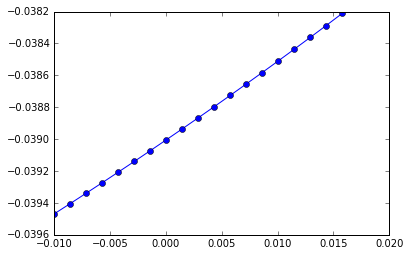

In [103]:
get_gap_list(0)
plt.plot(gamma_list, gap_list, 'o-')


  3%|▎         | 3/99 [00:04<02:15,  1.41s/it]
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 99/99 [02:43<00:00,  2.15s/it]


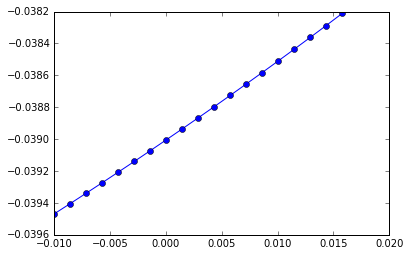

In [109]:
get_gap_list(49308)
plt.plot(gamma_list, gap_list, 'o-')

In [127]:
x, obj, details = query_graph_using_sparse_linear_solver(
    g, [[49308]], kappa=0.9, max_iter=50, verbose=1, return_details=True,
    ub=lambda1
)

matrices loading done
using given ub=0.01722530425428839
at iteration 5 (alpha=-31280.04581)
residual: sqrt(kappa) - y' D s=-0.05131670194576854
at iteration 10 (alpha=-977.48474)
residual: sqrt(kappa) - y' D s=-0.05131669815025375
at iteration 15 (alpha=-30.52971)
residual: sqrt(kappa) - y' D s=-0.051313042486495264
at iteration 20 (alpha=-0.93737)
residual: sqrt(kappa) - y' D s=-0.050312384312628966
at iteration 25 (alpha=-0.01261)
residual: sqrt(kappa) - y' D s=-0.04718486363009167
at iteration 30 (alpha=0.01629)
residual: sqrt(kappa) - y' D s=-0.046884389475305155
at iteration 35 (alpha=0.01720)
residual: sqrt(kappa) - y' D s=-0.046874396815103525
at iteration 40 (alpha=0.01722)
residual: sqrt(kappa) - y' D s=-0.04687408385922587
at iteration 45 (alpha=0.01723)
residual: sqrt(kappa) - y' D s=-0.04687407411474376
at iteration 50 (alpha=0.01723)
residual: sqrt(kappa) - y' D s=-0.04687407382483533


In [164]:
v1_C1, v1_C2, v1_C = sweep_on_x_fast(g, v1, top_k=200)[:3]

In [166]:
vect_diff = np.abs(v1 - x)
print('difference between lambda1 and alpha', np.abs(lambda1 - details['alpha']))
print('max|v1-x|=', vect_diff.max())
print('argmax|v1-x|==49308 (query)?', np.argmax(vect_diff) == 49308)
print('ranks of nodes by v1 by x', np.minimum(n-rankdata(x)[v1_C1], rankdata(x)[v1_C1]))
print('ranks of nodes by v1 by v1', np.minimum(n-rankdata(v1)[v1_C1], rankdata(v1)[v1_C1]))

difference between lambda1 and alpha 4.4451643407827923e-10
max|v1-x|= 0.7039649437462611
argmax|v1-x|==49308 (query)? True
ranks of nodes by v1 by x [28673.  31367.  24626.5 24626.5 22210.5 22210.5 22210.5 22210.5 19251. ]
ranks of nodes by v1 by v1 [0.  1.  2.5 2.5 4.  5.5 5.5 7.  8. ]


# What's weird?

- running query on 49308 gives $\alpha \approx \lambda_1$. So it should be the case that $x \approx v_1$
- however, we find $v_1$ and $x$ are quite different (the most different entry is the index of the query)

what could be the cause?

(<matplotlib.figure.Figure at 0x7f8ccc9d9be0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c6b1943c8>)

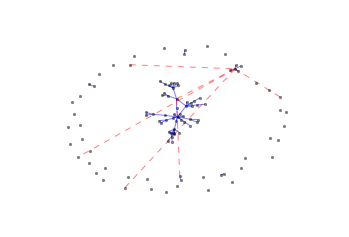

In [165]:
C1, C2, C = sweep_on_x_fast(g, x, top_k=200)[:3]
draw_graph(C, use_lcc=False)

In [13]:
def draw_graph(C, layout='pos', show_query=False, r=None, use_lcc=True):
    assert layout in {'pos', 'spectral'}
    subg = g.subgraph(C)
    if use_lcc:
        print('use largest CC')
        subg = get_lcc(subg)
    mapping = {n: i for i, n in enumerate(subg.nodes())}
    subg = nx.relabel_nodes(subg, mapping=mapping)

    if layout == 'pos':
        pos = pos_spring_layout(subg)
    else:
        pos = signed_layout(subg)

    fig, ax = get_borderless_fig()
    # draw_nodes(subg, pos, ax=ax)
    nx.draw_networkx_nodes(subg, pos, node_size=10, linewidths=0, alpha=0.5, node_color='black')        
    if show_query:
        nx.draw_networkx_nodes(subg, pos, nodelist=[mapping[r['query']]],
                               node_size=80, linewidths=0,
                               node_color='green',
                               node_shape='s')
    draw_edges(subg, pos, ax=ax, width=1.0, alpha=0.5)
    return fig, ax

# try some random seeds

In [169]:
lambda1

0.01722530425428839

In [170]:
np.random.seed(12345)

for seed in np.random.permutation(g.number_of_nodes())[:5]:
    print('seed', seed)
    x, obj, details = query_graph_using_sparse_linear_solver(
        g, [[seed]], kappa=0.9, max_iter=100, verbose=1, return_details=True,
        ub=lambda1
    )

seed 63307
matrices loading done
using given ub=0.01722530425428839
at iteration 5 (alpha=-31280.04581)
residual: sqrt(kappa) - y' D s=-0.05131670194948623
at iteration 10 (alpha=-977.48474)
residual: sqrt(kappa) - y' D s=-0.051316701949335575
at iteration 15 (alpha=-30.52971)
residual: sqrt(kappa) - y' D s=-0.051316701769011264
at iteration 20 (alpha=-0.93737)
residual: sqrt(kappa) - y' D s=-0.05131342582102838
at iteration 25 (alpha=-0.01261)
residual: sqrt(kappa) - y' D s=-0.05124341244772168
at iteration 30 (alpha=0.01629)
residual: sqrt(kappa) - y' D s=-0.05122700450341555
at iteration 35 (alpha=0.01720)
residual: sqrt(kappa) - y' D s=-0.051193713867859536
at iteration 40 (alpha=0.01722)
residual: sqrt(kappa) - y' D s=-0.019268292838795054
at iteration 45 (alpha=0.01722)
residual: sqrt(kappa) - y' D s=-0.0003985334956906339
terminates after 45 iterations:
  - alpha=0.01722
  - residual=-0.00040
seed 74692
matrices loading done
using given ub=0.01722530425428839
at iteration 5 (alp

# how about other graphs

In [195]:
def try_graph(graph_name):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph_name))
    A = nx.adj_matrix(g, weight='sign')

    n = g.number_of_nodes()
    L = signed_laplacian(g)
    Ln = signed_normalized_laplacian(A)
    D = degree_diag(g)

    l, v = eigs(Ln, k=1, which='SM')  # the smallest eigen value
    lambda1 = np.real(l[0])
    v1 = np.real(flatten(v))
    
    np.random.seed(12345)
    print('lambda1', lambda1)
    for seed in np.random.permutation(g.number_of_nodes())[:5]:
        print('seed', seed, 'of degree', g.degree(seed))
        x, obj, details = query_graph_using_sparse_linear_solver(
            g, [[seed]], kappa=0.9, max_iter=50, verbose=1, return_details=True,
            ub=lambda1
        )
        print('alpha - lambda1={}'.format(details['alpha'] - lambda1))
        print()

In [192]:
try_graph('bitcoin')

lambda1 0.03980619225546313
seed 1584 of degree 2
matrices loading done
using given ub=0.03980619225546313
at iteration 5 (alpha=-1343.02394)
residual: sqrt(kappa) - y' D s=-0.05131670187145465
at iteration 10 (alpha=-41.93094)
residual: sqrt(kappa) - y' D s=-0.05131662525597358
at iteration 15 (alpha=-1.27178)
residual: sqrt(kappa) - y' D s=-0.051255005035898415
at iteration 20 (alpha=-0.00118)
residual: sqrt(kappa) - y' D s=-0.048912233738692135
at iteration 25 (alpha=0.03853)
residual: sqrt(kappa) - y' D s=-0.043995277824330103
at iteration 30 (alpha=0.03961)
residual: sqrt(kappa) - y' D s=0.011728889128212683
terminates after 34 iterations:
  - alpha=0.03958
  - residual=-0.00040
alpha - lambda1=-0.00022765025626655944

seed 4042 of degree 2
matrices loading done
using given ub=0.03980619225546313
at iteration 5 (alpha=-1343.02394)
residual: sqrt(kappa) - y' D s=-0.0513166985290574
at iteration 10 (alpha=-41.93094)
residual: sqrt(kappa) - y' D s=-0.05131334863998693
at iteration 15

In [193]:
try_graph('word')

lambda1 0.029549341418420864
seed 727 of degree 9
matrices loading done
using given ub=0.029549341418420864
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.05131669930146898
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.051313927809822024
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.04944951499537076
at iteration 20 (alpha=-0.59914)
residual: sqrt(kappa) - y' D s=0.23081931508867948
at iteration 25 (alpha=-0.65808)
residual: sqrt(kappa) - y' D s=-0.0011562287376739588
terminates after 27 iterations:
  - alpha=-0.65738
  - residual=-0.00053
alpha - lambda1=-0.6869311103880797

seed 3173 of degree 14
matrices loading done
using given ub=0.029549341418420864
at iteration 5 (alpha=-2942.97137)
residual: sqrt(kappa) - y' D s=-0.05131668583523785
at iteration 10 (alpha=-91.93923)
residual: sqrt(kappa) - y' D s=-0.05130029450301632
at iteration 15 (alpha=-2.84447)
residual: sqrt(kappa) - y' D s=-0.035972402002927284
at iteration

In [196]:
try_graph('slashdot')

lambda1 0.0172253042542885
seed 63307 of degree 1
matrices loading done
using given ub=0.0172253042542885
at iteration 5 (alpha=-31280.04581)
residual: sqrt(kappa) - y' D s=-0.05131670194948623
at iteration 10 (alpha=-977.48474)
residual: sqrt(kappa) - y' D s=-0.051316701949335575
at iteration 15 (alpha=-30.52971)
residual: sqrt(kappa) - y' D s=-0.051316701769011264
at iteration 20 (alpha=-0.93737)
residual: sqrt(kappa) - y' D s=-0.05131342582298282
at iteration 25 (alpha=-0.01261)
residual: sqrt(kappa) - y' D s=-0.0512434124340434
at iteration 30 (alpha=0.01629)
residual: sqrt(kappa) - y' D s=-0.051227004212562544
at iteration 35 (alpha=0.01720)
residual: sqrt(kappa) - y' D s=-0.05119370996868078
at iteration 40 (alpha=0.01722)
residual: sqrt(kappa) - y' D s=-0.0192685125205313
at iteration 45 (alpha=0.01722)
residual: sqrt(kappa) - y' D s=-0.0003985621098649972
terminates after 45 iterations:
  - alpha=0.01722
  - residual=-0.00040
alpha - lambda1=-7.112262901086408e-07

seed 74692 o

In [198]:
try_graph('epinions')

lambda1 0.011227776937344317
seed 93647 of degree 1
matrices loading done
using given ub=0.011227776937344317
at iteration 5 (alpha=-44016.67662)
residual: sqrt(kappa) - y' D s=-0.05131670194816962
at iteration 10 (alpha=-1375.51027)
residual: sqrt(kappa) - y' D s=-0.051316700603145304
at iteration 15 (alpha=-42.97382)
residual: sqrt(kappa) - y' D s=-0.05131537849977341
at iteration 20 (alpha=-1.33205)
residual: sqrt(kappa) - y' D s=-0.05021506278186849
at iteration 25 (alpha=-0.03075)
residual: sqrt(kappa) - y' D s=-0.0010748522895934753
terminates after 29 iterations:
  - alpha=-0.02813
  - residual=-0.00010
alpha - lambda1=-0.039353985653103614

seed 18084 of degree 30
matrices loading done
using given ub=0.011227776937344317
at iteration 5 (alpha=-44016.67662)
residual: sqrt(kappa) - y' D s=-0.05131670194948601
at iteration 10 (alpha=-1375.51027)
residual: sqrt(kappa) - y' D s=-0.051316360829535945
at iteration 15 (alpha=-42.97382)
residual: sqrt(kappa) - y' D s=-0.0509824856990548

# guess: low degree nodes tend to have $\alpha \approx \lambda_1$

intuition: 

- if a node's degree is 1, it's "similar" to a singleton node.
- for querying on a singleton node $q$, the following solution $x^{'}$ achieves objective close to $\lambda_1$:
  - putting high value to $x^{'}(q)$ (to satisfy the correlation constraint) and this part does not increase the objective because of no incident edges to $q$
  - for the values on the rest of $x^{'}$, make it similar to $v_1$
- **I assume** the closer $x^{'}$ is to $v_1$, the closer $\alpha$ is to $\lambda_1$
- if $\alpha  \approx \lambda_1$ (empirically observed), $\beta$ tends to 0 (due to Case 1 in the proof of Claim 4), therefore the correlation constraint does not need to tight


In [215]:

def degree_experiment_on_graph(graph_name):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph_name))
    A = nx.adj_matrix(g, weight='sign')

    n = g.number_of_nodes()
    L = signed_laplacian(g)
    Ln = signed_normalized_laplacian(A)
    D = degree_diag(g)

    deg = D.diagonal()
    low_degree_nodes = list(map(int, np.argsort(deg)[:5]))
    high_degree_nodes = list(map(int, np.argsort(deg)[-5:]))

    l, v = eigs(Ln, k=1, which='SM')  # the smallest eigen value
    lambda1 = np.real(l[0])
    v1 = np.real(flatten(v))

    print('lambda1', lambda1)

    print('-------high degree nodes-------')
    for seed in high_degree_nodes:
        print('seed', seed, 'of degree', g.degree(seed))
        x, obj, details = query_graph_using_sparse_linear_solver(
            g, [[seed]], kappa=0.9, max_iter=50, verbose=0, return_details=True,
            ub=lambda1
        )
        print(details)
        print('alpha - lambda1={}'.format(details['alpha'] - lambda1))
        print()    


    print('-------low degree nodes-------')
    for seed in low_degree_nodes:
        print('seed', seed, 'of degree', g.degree(seed))
        x, obj, details = query_graph_using_sparse_linear_solver(
            g, [[seed]], kappa=0.9, max_iter=50, verbose=0, return_details=True,
            ub=lambda1
        )
        print(details)
        print('alpha - lambda1={}'.format(details['alpha'] - lambda1))
        print()



In [216]:
degree_experiment_on_graph('bitcoin')

lambda1 0.03980619225546311
-------high degree nodes-------
seed 1980 of degree 326
{'converged': True, 'ub': -18.978186275694604, 'alpha': -19.306082697555812, 'lb': -19.63397911941702, 'gap': -0.0008234565842575314, 'n_iters': 17}
alpha - lambda1=-19.345888889811274

seed 2071 of degree 436
{'converged': True, 'ub': -33.40562883758775, 'alpha': -33.73352525944895, 'lb': -34.061421681310165, 'gap': -0.0005347017948809096, 'n_iters': 17}
alpha - lambda1=-33.773331451704415

seed 2571 of degree 438
{'converged': True, 'ub': -24.880321869196344, 'alpha': -25.208218291057552, 'lb': -25.53611471291876, 'gap': -0.00028132602556962816, 'n_iters': 17}
alpha - lambda1=-25.248024483313014

seed 1785 of degree 439
{'converged': True, 'ub': -20.289771963139437, 'alpha': -20.61766838500064, 'lb': -20.94556480686185, 'gap': -0.00040047829767742016, 'n_iters': 17}
alpha - lambda1=-20.657474577256103

seed 23 of degree 795
{'converged': True, 'ub': -53.735206992982654, 'alpha': -54.39099983670507, 'l

In [217]:
degree_experiment_on_graph('slashdot')

lambda1 0.01722530425428827
-------high degree nodes-------
seed 31 of degree 1727
{'converged': True, 'ub': -21.46108946507988, 'alpha': -21.699737406961372, 'lb': -21.938385348842864, 'gap': -0.0004753992612250846, 'n_iters': 22}
alpha - lambda1=-21.71696271121566

seed 135 of degree 1861
{'converged': True, 'ub': -48.66695483956983, 'alpha': -49.14425072333282, 'lb': -49.621546607095794, 'gap': -0.0007908123394283484, 'n_iters': 21}
alpha - lambda1=-49.161476027587106

seed 60 of degree 2290
{'converged': True, 'ub': -13.347059441109195, 'alpha': -13.824355324872176, 'lb': -14.301651208635157, 'gap': -0.0009490402623595351, 'n_iters': 21}
alpha - lambda1=-13.841580629126465

seed 122 of degree 2347
{'converged': True, 'ub': -41.030220699362125, 'alpha': -41.50751658312511, 'lb': -41.98481246688809, 'gap': -0.0007756493546826615, 'n_iters': 21}
alpha - lambda1=-41.5247418873794

seed 132 of degree 2548
{'converged': True, 'ub': -42.93940423441405, 'alpha': -43.41670011817703, 'lb': -

# explaining why $\alpha \approx \lambda_1$ by checking $(Ds)(Ds)^T$

we compare two seeds, one with degree 1 and the other with degree max and show their corresponding $(Ds)(Ds)^T$

- we found that for large degree nodes, its non-zero entry in $(Ds)(Ds)^T$ is much larger (actually, equal to its degree)


Recall that due to complementary slackness and rank-1 result, we need to solve this problem:

$x (L_G - \alpha D - \beta (Ds)(Ds)^T) = 0$

If $(Ds)(Ds)^T$ is insignificant and $\beta$ is small, the last subtracting term can be ignored. 

And the problem becomes approximately: 

$x (L_G - \alpha D) \approx 0$ (reminding me of the charactertic polynomial and generalized eigen-problem)

which gives $\alpha \approx \lambda_1$

In [266]:
seed1 = 49309
print('seed 1 degree', g.degree(seed1))
seed2 = 132
print('seed 2 degree', g.degree(seed2))

seed 1 degree 1
seed 2 degree 2548


In [269]:
s1 = prepare_seed_vector_sparse([[seed1]], D)
s2 = prepare_seed_vector_sparse([[seed2]], D)
print('non-zero entry of s1:', s1.data[0])
print('non-zero entry of s2:', s2.data[0])

non-zero entry of s1: 1.0
non-zero entry of s2: 0.019810721293758184


In [270]:
Ds1 = (D @ s1)
Ds2 = (D @ s2)
print('nonzero entry of Ds1 (Ds1).T: ', (Ds1 @ Ds1.T).data[0])
print('nonzero entry of Ds2 (Ds2).T: ', (Ds2 @ Ds2.T).data[0])

nonzero entry of Ds1 (Ds1).T:  1.0
nonzero entry of Ds2 (Ds2).T:  2548.0


# what's missing?

- low degree nodes have insignificant $(Ds)(Ds)^T$, however, by setting $\beta$ large, it could still make a big impact. What's the value of $\beta$ for low degree nodes? 
  - on one hand, $\beta$ should be close to zero in order to untighten the correlation constraint. 
  - on the other hand, $\beta$ should be large in order to maximize the dual problem objective
  - so what's the happening here?